<center><h1><b><u>Analysis of Graphs</u></b></h1></center>

## __Importing Libraries, Classes, and Functions__

In [38]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx #focuses on network analysis and graph theory; can create/visualize graphs
import inspect #for viewing source code

In [290]:
#getsource finds file of Code, start and end lines of def and outputs them
source_code = inspect.getsource(nx.Graph)

#with open('../source.py', 'w') as file:
    #file.write(source_code)

## __Undirected Graph Implementations__

### __Custom One Hot Encoder__

In [40]:
class CustomOneHotEncoder:
    def __init__(self):
        self._categories = None #fit-related attributes not calculated in __init__
        self._cat_idx_map = None

    def fit(self, categories): #"learning" the unique categories
        self._categories = sorted(set(categories)) #encoding based lexographically usually; e.g. ['Carbon', 'Hydrogen']
        self._col_idx_map = {category: idx for idx, category in enumerate(self._categories)} #Indexing each category for column index {Carbon:0, Hydrogen, 1}
    
    def transform(self, category):
        one_hot = np.zeros(len(self._categories))
        one_hot[self._col_idx_map[category]] = 1
        return one_hot
    
    def fit_transform(self, categories):
        self.fit(categories)
        return [self.transform(category) for category in categories]


In [413]:
categories = ['Carbon', 'Hydrogen']
encoder = CustomOneHotEncoder()
#encoded_data = encoder.fit_transform(data)
encoder.fit(categories)
encoded = encoder.transform('Carbon') #needs to be list because transform expects 2D array
print(encoded)

[1. 0.]


### __Static Matrix Implementation__

In [45]:
class GraphMS: #Graph Matrix Static
    ATOM_TYPES = ['C', 'H', 'O'] #Carbon, Hydrogen, Oxygen

    def __init__(self, max_nodes = 6, max_edges = 12, **global_attributes):
        self._max_nodes = max_nodes
        self._max_edges = max_edges
        self._edge_pair_count = 0
        self._adj = np.zeros((max_nodes, max_nodes))
        self._node = None 
        self._edge = None
        self._node_indices = {}
        self._index_counter = 0
        self._graph = global_attributes
        self.encoder = CustomOneHotEncoder()

    def _create_node_feature_matrix(self):
        new_features = len(GraphMS.ATOM_TYPES) + 1  # +1 for non_bonding_valence
        self._node = np.zeros((self._max_nodes, new_features)) #Predefined 10 nodes
    
    def _add_node_features(self, row, non_bonding, atom_type):
        one_hot_atom = self.encoder.transform(atom_type) # [0 ...1..0]
            
        self._node[row, :len(one_hot_atom)] = one_hot_atom  # no looping, vectorized; put that vector in every element of row besides last column
        self._node[row, -1] = non_bonding  # last element of row

    def add_node(self, node_attributes):
        if self._index_counter < self._max_nodes: #if space for node
            node_label = node_attributes['label']
            non_bonding = node_attributes['non_bonding_valence']
            atom_type = node_attributes['atom']

            self._node_indices[node_label] = self._index_counter #index in adj matrix
            row = self._index_counter #nth node corresponds to index row of feature matrix

            if self._node is None:
                self._create_node_feature_matrix()
                self.encoder.fit(GraphMS.ATOM_TYPES)  #updates categories and respective column indices
            
            self._add_node_features(row, non_bonding, atom_type)
            
            self._index_counter += 1
        else:
            print("Not enough space allocated.")
        
    def _check_missing_nodes(self, node1_label, node2_label):
        if node1_label not in self._node_indices and node2_label not in self._node_indices:
            raise ValueError(f'Missing {node1_label} and {node2_label}')
        elif node1_label not in self._node_indices:
            raise ValueError(f'Missing {node1_label}')
        elif node2_label not in self._node_indices:
            raise ValueError(f'Missing {node2_label}')
        
    
    def _add_edge_features(self, edge_features, reverse=False):
        if self._edge_pair_count >= self._max_edges/2:
            raise ValueError("Maximum number of edges reached")

        if not reverse:
            row_idx = self._edge_pair_count * 2
        else:
            row_idx = self._edge_pair_count * 2 + 1 #row index for reverse edge is the one after not reverse
        
        for col_idx, (attribute, attribute_val) in enumerate(edge_features.items()):
            self._edge[row_idx, col_idx] = attribute_val  # bond order

        if reverse:
            self._edge_pair_count += 1 #every edge is technically adding two

    def add_edge(self, node1_label, node2_label, edge_features):
        self._check_missing_nodes(node1_label, node2_label)

        i, j = self._node_indices[node1_label], self._node_indices[node2_label]
        
        self._adj[i, j] = 1 #numpy indexing works like normal matrix; can use [i, j] instead of [i][j]
        self._adj[j, i] = 1 #Edge goes both ways for undirected

        if self._edge is None:
            self._edge = np.zeros((self._max_edges, len(edge_features))) #predefine 10 max edges

        self._add_edge_features(edge_features)
        self._add_edge_features(edge_features, reverse = True)
    
    def is_connection(self, i, j):
        return self._adj[i, j] == 1
    
    def to_nx(self):
        G = nx.Graph()
        
        for node_label in self._node_indices:
            G.add_node(node_label) #G is using nx methods; adjacency list by default

        added_edges = set() #so edges aren't repeatedly added to G
        count = 0
        for node1, i in self._node_indices.items(): #H1, 0; labels must be unique
            for node2, j in self._node_indices.items(): 
                if self.is_connection(i, j) and (i, j) not in added_edges and (j, i) not in added_edges: #only add if edge not seen
                    bond_order = self._edge[(count * 2), 0]
                    G.add_edge(node1, node2, bond_order=bond_order)  #don't need to add edge in both directions explicitly
                    added_edges.add((i, j))
                    added_edges.add((j, i))
                    count += 1
        
        return G
    
    def visualize(self):
        G = self.to_nx()
        pos = nx.spring_layout(G) #computes positions of the nodes on the graph so theres as few edge crossings possible and edge are around same length; pos = {label: [x,y], ...}

        edges = G.edges(data=True) #[(H1, O, {bond_order: 2}), ...]; can get attributes with methods that go through dicts in each tuple; G._adj contains this info
        bond_orders = [attribute_dict['bond_order'] for node1, node2, attribute_dict in edges] #list of the weights

        plt.figure(figsize=(6,6))
        nx.draw(G, pos, with_labels=True, width = bond_orders, node_color='#ff91af', edge_color='pink', font_size = 9, node_size = 2000) 
        
        edge_labels = nx.get_edge_attributes(G, 'bond_order') #iterates through all the attributedict[bondorder] in _adj; creates {('H1', 'O'): 1, ('H2', 'O'): 1}
        nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

    def _print_matrix(self, name, matrix):
        print(name)
        for row in matrix:
            print(" ".join(str(element) for element in row)) #join method works with any iterable, including generator
        print()
    
    def __str__(self):
        print(f'Graph Attributes: {self._graph}')
        self._print_matrix("Adjacency Matrix:", self._adj)
        self._print_matrix("Node Feature Matrix:", self._node)
        self._print_matrix("Edge Feature Matrix:", self._edge)

        connections = [] #printing connection of every node
        for node1, i in self._node_indices.items():
            for node2, j in self._node_indices.items():
                ij_connection = self._adj[i, j]
                if self.is_connection(i, j):
                    connections.append(f"{node1} -- {node2}, Bond Order: {ij_connection}")
        return "\n".join(connections)

In [195]:
graph = GraphMS(max_nodes = 4, max_edges = 8, name="H2O")


graph.add_node(dict(label = 'H1', atom = 'H', non_bonding_valence = 0))
graph.add_node(dict(label = 'O', atom = 'O', non_bonding_valence = 4))
graph.add_node(dict(label = 'H2', atom = 'H', non_bonding_valence = 0))

try:
    graph.add_edge('H1', 'O', dict(bond_order=1)) #or {'bond_order': 1}
    graph.add_edge('H2', 'O', dict(bond_order=1))
except ValueError as e:
    print(e)

print(graph)

Graph Attributes: {'name': 'H2O'}
Adjacency Matrix:
0.0 1.0 0.0 0.0
1.0 0.0 1.0 0.0
0.0 1.0 0.0 0.0
0.0 0.0 0.0 0.0

Node Feature Matrix:
0.0 1.0 0.0 0.0
0.0 0.0 1.0 4.0
0.0 1.0 0.0 0.0
0.0 0.0 0.0 0.0

Edge Feature Matrix:
1.0
1.0
1.0
1.0
0.0
0.0
0.0
0.0

H1 -- O, Bond Order: 1.0
O -- H1, Bond Order: 1.0
O -- H2, Bond Order: 1.0
H2 -- O, Bond Order: 1.0


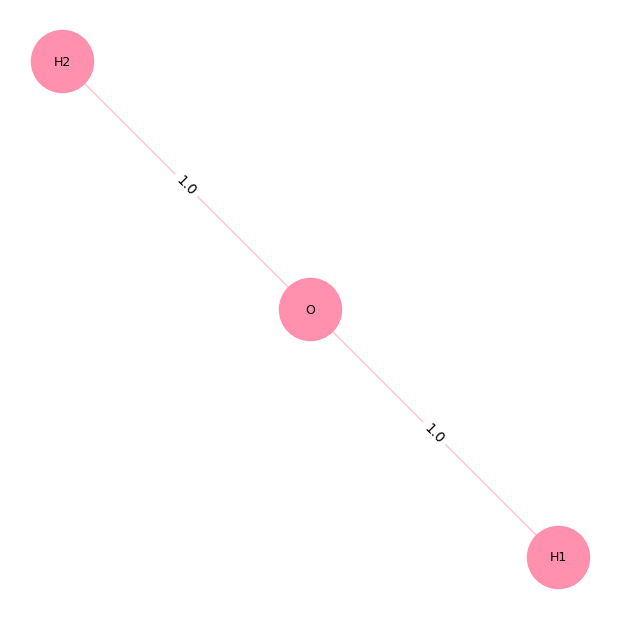

In [47]:
graph.visualize()

### __Dynamic Matrix Implementation__

In [54]:
class GraphMD: # Graph Matrix Dynamic
    class Node:
        ATOM_TYPES = ['C', 'H', 'O'] # Carbon, Hydrogen, Oxygen
        def __init__(self, label, atom_type, non_bonding_valence, encoder):
            self.label = label
            self.atom_type = atom_type
            self.non_bonding_valence = non_bonding_valence
            self.encoder = encoder
            self.features = None #[one_hot_atom_type   non_bonding]; Feature matrices can be created now once the graph is complete
            
        def create_feature_vector(self): 
            one_hot_atom = self.encoder.transform(self.atom_type)
            self.features = np.append(one_hot_atom, self.non_bonding_valence) #combines the two into single array

    class Edge:
        def __init__(self, node1, node2, edge_features):
            self.node1 = node1
            self.node2 = node2
            self.features_dict = edge_features
            self.features = None

        def create_feature_vector(self):
            self.features = np.array(list(self.features_dict.values())) #[bond_order]

    def __init__(self, max_nodes=6, max_edges=12, **global_attributes): #** in function definition -> it packs keyword arguments into a dictionary
        self._max_nodes = max_nodes
        self._max_edges = max_edges
        self._adj = np.zeros((max_nodes, max_nodes))
        self._nodes = {} #way to access all the node objects
        self._edges = [] #list of edge objects
        self.encoder = CustomOneHotEncoder()
        self._graph = global_attributes
    
    def add_node(self, node_attributes):
        if not self._nodes: #if no nodes in graph
            self.encoder.fit(GraphMD.Node.ATOM_TYPES) #get categories and indices during graph creation

        if len(self._nodes) < self._max_nodes:
            node = GraphMD.Node(node_attributes['label'], node_attributes['atom'], node_attributes['non_bonding_valence'], self.encoder)
            node.create_feature_vector()
            self._nodes[node.label] = node #add node to dict
        else:
            raise ValueError("Not enough node space allocated.")
    
    def add_edge(self, node1_label, node2_label, **edge_features):
        if node1_label in self._nodes and node2_label in self._nodes:
            i, j = list(self._nodes.keys()).index(node1_label), list(self._nodes.keys()).index(node2_label) #indices for _adj

            #Add edges to adjacency list
            self._adj[i, j] = 1
            self._adj[j, i] = 1
        
            #Create features/edge objects
            edge = GraphMD.Edge(node1_label, node2_label, edge_features) 
            edge.create_feature_vector()
            reverse_edge = GraphMD.Edge(node2_label, node1_label, edge_features)
            reverse_edge.create_feature_vector()

            self._edges.append(edge)
            self._edges.append(reverse_edge)
        else:
            raise ValueError("One or both nodes missing.")
    
    def is_connection(self, i, j):
        return self._adj[i, j] == 1
    
    def to_nx(self):
        G = nx.Graph()
        for node_label in self._nodes:
            G.add_node(node_label)
        
        for edge in self._edges:
            G.add_edge(edge.node1, edge.node2, **edge.features_dict) #passing bond_order=1; #** unpacks in function call
        
        return G
    
    def visualize(self):
        G = self.to_nx()
        pos = nx.spring_layout(G)
        edges = G.edges(data=True)
        bond_orders = [attribute['bond_order'] for node, node2, attribute in edges]
        
        plt.figure(figsize=(6, 6))
        nx.draw(G, pos, with_labels=True, width=bond_orders, node_color='#ff91af', edge_color='pink', font_size=9, node_size=2000)
        edge_labels = nx.get_edge_attributes(G, 'bond_order')
        nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
    
    def _print_matrix(self, name, matrix):
        print(name)
        for row in matrix:
            print(" ".join(str(element) for element in row))
        print()
    
    def __str__(self):
        print(f'Graph Attributes: {self._graph}')
        self._print_matrix("Adjacency Matrix:", self._adj)
        node_features = np.array([node.features for node in self._nodes.values()]) #creating the node feature matrix by combining all node feature vectors
        self._print_matrix("Node Feature Matrix:", node_features)
        
        #Create and print edge feature matrix
        num_edge_features = len(self._edges[0].features)
        edge_features = np.zeros((len(self._edges), num_edge_features))
        for idx, edge in enumerate(self._edges):
            edge_features[idx] = edge.features #replace feature rows with actual features from dict
        self._print_matrix("Edge Feature Matrix:", edge_features)
        
        connections = []
        for edge in self._edges:
            connections.append(f"{edge.node1} -- {edge.node2}, Bond Order: {edge.features_dict['bond_order']}")
        return "\n".join(connections)

In [55]:
water = GraphMD(max_nodes = 3, max_edges = 6, name="H2O")
water.add_node({'label': 'H1', 'atom': 'H', 'non_bonding_valence': 0})
water.add_node({'label': 'O', 'atom': 'O', 'non_bonding_valence': 4})
water.add_node({'label': 'H2', 'atom': 'H', 'non_bonding_valence': 0})
water.add_edge('H1', 'O', bond_order=1)
water.add_edge('H2', 'O', bond_order=1)

print(water)

Graph Attributes: {'name': 'H2O'}
Adjacency Matrix:
0.0 1.0 0.0
1.0 0.0 1.0
0.0 1.0 0.0

Node Feature Matrix:
0.0 1.0 0.0 0.0
0.0 0.0 1.0 4.0
0.0 1.0 0.0 0.0

Edge Feature Matrix:
1.0
1.0
1.0
1.0

H1 -- O, Bond Order: 1
O -- H1, Bond Order: 1
H2 -- O, Bond Order: 1
O -- H2, Bond Order: 1


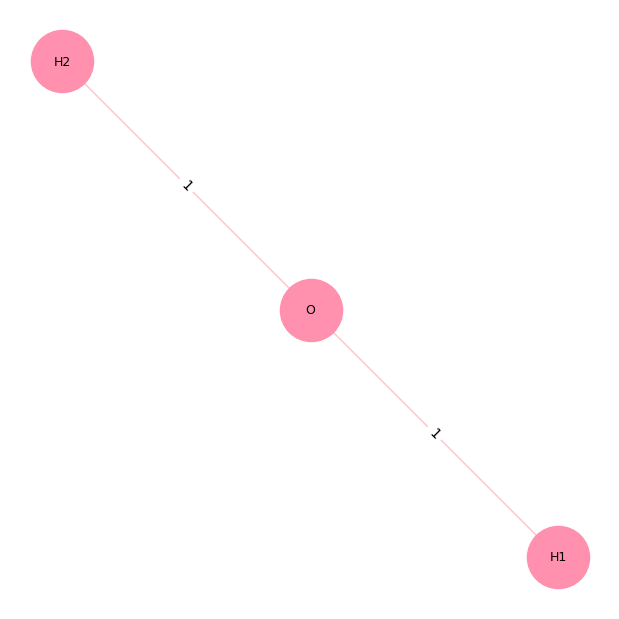

In [50]:
water.visualize()

### __Visualizing the Graph__

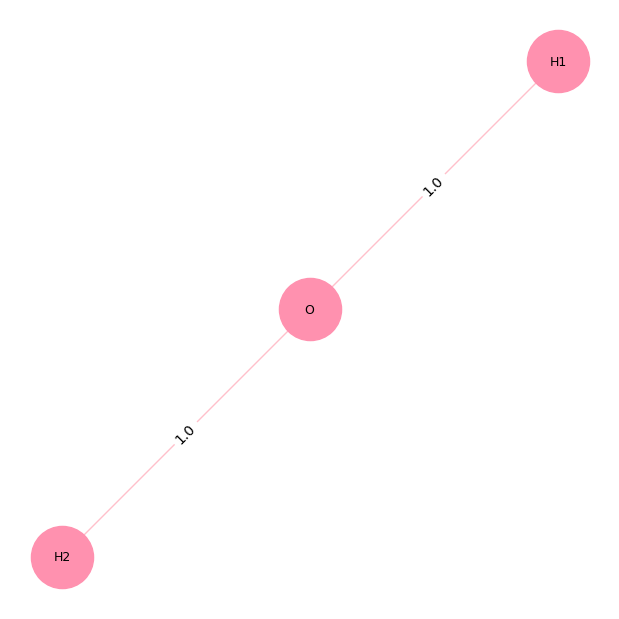

In [196]:
graph.visualize()

### __Dynamic Matrix Implementation__

In [10]:
class GraphM:
    def __init__(self, num_nodes = 5):
        self._num_nodes = num_nodes
        self._adj_matrix = np.zeros((num_nodes, num_nodes))
        self._node_features = np.zeros((num_nodes, num_nodes))
        self._edge_features = {} #node_label: identifier/index of adj matrix
        self._index_counter = 0

    def add_node(self, node_label):
        if self._index_counter < self._num_nodes: #nth node is n-1 index
            self._node_indices[node_label] = self._index_counter # {A: 0, B: 1...}
            self._index_counter += 1
        else:
            print("Not enough space allocated.")

    def add_edge(self, node1, node2, weight):
        
        if node1 not in self._node_indices:
            self.add_node(node1)
        if node2 not in self._node_indices:
            self.add_node(node2)
        i, j = self._node_indices[node1], self._node_indices[node2]
        self._adj_matrix[i, j] = weight
        self._adj_matrix[j, i] = weight  #Edge goes both ways for undirected

    @property
    def display_matrix(self):
        return self._adj_matrix

    def is_connection(self, i, j):
        return self._adj_matrix[i, j] != 0
    
    def to_nx(self):
        G = nx.Graph()
        
        for node_label in self._node_indices: #accesses keys without .items()
            G.add_node(node_label) #G is using nx methods; adjacency list by default

        for node1, i in self._node_indices.items():
            for node2, j in self._node_indices.items():
                weight = self._adj_matrix[i, j]
                if self.is_connection(i,j):
                    G.add_edge(node1, node2, weight=weight) #keyword argument added to attribute dict
        
        return G
    
    def visualize(self):
        G = self.to_nx()
        pos = nx.spring_layout(G) #computes positions of the nodes on the graph so theres as few edge crossings possible and edge are around same length; pos = {label: [x,y], ...}

        edges = G.edges(data=True) #[(A, B, {edgeattribute1: 2}), ...]; can get attributes with methods that go through dicts in each tuple
        weights = [attribute['weight'] for node1, node2, attribute in edges] #list of the weights

        plt.figure(figsize=(6,6))
        nx.draw(G, pos, with_labels=True, width = weights, node_color='#ff91af', edge_color='pink', font_size = 9, node_size = 2000) 
        
        edge_labels = nx.get_edge_attributes(G, 'weight') #{(A,B): weight}
        nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
    
    def __str__(self):
        print("")
        connections = [] #printing connection of every node
        for node1, i in self._node_indices.items():
            for node2, j in self._node_indices.items():
                ij_connection = self._adj_matrix[i, j]
                if self.is_connection(i, j):
                    connections.append(f"{node1}--{node2}, Weight: {ij_connection}")
        return "\n".join(connections)

### __Dictionary Implementation__

In [294]:
'''Weight of edge stored in the adjacency matrix. Attempting to mimic MUTAG.'''

class GraphM:
    def __init__(self, num_nodes = 5):
        self._num_nodes = num_nodes
        self._adj_matrix = np.zeros((num_nodes, num_nodes))
        self._node_indices = {} #node_label: identifier/index of adj matrix
        self._index_counter = 0

    def add_node(self, node_label):
        if self._index_counter < self._num_nodes: #nth node is n-1 index
            self._node_indices[node_label] = self._index_counter # {A: 0, B: 1...}
            self._index_counter += 1
        else:
            print("Not enough space allocated.")

    def add_edge(self, node1, node2, weight):
        
        if node1 not in self._node_indices:
            self.add_node(node1)
        if node2 not in self._node_indices:
            self.add_node(node2)
        i, j = self._node_indices[node1], self._node_indices[node2]
        self._adj_matrix[i, j] = weight
        self._adj_matrix[j, i] = weight  #Edge goes both ways for undirected

    @property
    def display_matrix(self):
        return self._adj_matrix

    def is_connection(self, i, j):
        return self._adj_matrix[i, j] != 0
    
    def to_nx(self):
        G = nx.Graph()
        
        for node_label in self._node_indices: #accesses keys without .items()
            G.add_node(node_label) #G is using nx methods; adjacency list by default

        for node1, i in self._node_indices.items():
            for node2, j in self._node_indices.items():
                weight = self._adj_matrix[i, j]
                if self.is_connection(i,j):
                    G.add_edge(node1, node2, weight=weight) #keyword argument added to attribute dict
        
        return G
    
    def visualize(self):
        G = self.to_nx()
        pos = nx.spring_layout(G) #computes positions of the nodes on the graph so theres as few edge crossings possible and edge are around same length; pos = {label: [x,y], ...}

        edges = G.edges(data=True) #[(A, B, {edgeattribute1: 2}), ...]; can get attributes with methods that go through dicts in each tuple
        weights = [attribute['weight'] for node1, node2, attribute in edges] #list of the weights

        plt.figure(figsize=(6,6))
        nx.draw(G, pos, with_labels=True, width = weights, node_color='#ff91af', edge_color='pink', font_size = 9, node_size = 2000) 
        
        edge_labels = nx.get_edge_attributes(G, 'weight') #{(A,B): weight}
        nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
    
    def __str__(self):
        print("")
        connections = [] #printing connection of every node
        for node1, i in self._node_indices.items():
            for node2, j in self._node_indices.items():
                ij_connection = self._adj_matrix[i, j]
                if self.is_connection(i, j):
                    connections.append(f"{node1}--{node2}, Weight: {ij_connection}")
        return "\n".join(connections)

### __Instantiating the Graph__

In [295]:
graph = GraphM()

graph.add_edge('H1', 'O', 1)
graph.add_edge('H2', 'O', 1) 

print(graph._adj_matrix)
print(graph)

[[0. 1. 0. 0. 0.]
 [1. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]

H1--O, Weight: 1.0
O--H1, Weight: 1.0
O--H2, Weight: 1.0
H2--O, Weight: 1.0


### __Visualizing the Graph__

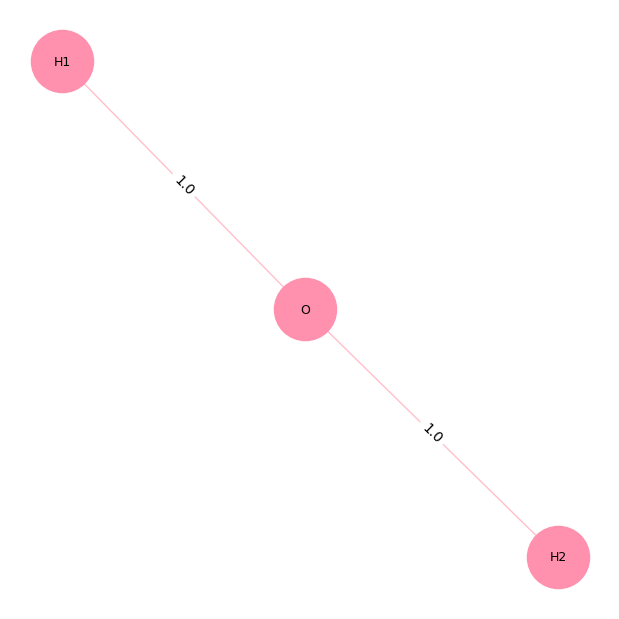

In [296]:
graph.visualize()